# Scrip to load boxplot images

## Imports

In [ ]:
from IPython.display import clear_output
!pip install sktime
clear_output()

In [ ]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imageio
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import re 
import math
import gc

from pathlib import Path 
from zipfile import ZipFile
from PIL import Image
from sktime.datasets import load_from_tsfile_to_dataframe
from sklearn.model_selection import KFold

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

## Functions

In [ ]:
def pureBlackAndWhiteImageArrayUpdated( imageArray, normalized = True):
  aux = imageArray != 0
  result = aux.astype("uint8")[:,:,:1]
  return result if normalized else (result*255)

In [ ]:
def array2img ( array, mode = "L" ):
    """
    @brief Convert a Matplotlib figure to a PIL Image in RGBA format and return it
    @param fig a matplotlib figure
    @return a Python Imaging Library ( PIL ) image
    """
    # put the figure pixmap into a numpy array
    h, w, d = array.shape
    return Image.frombytes( mode, ( w, h ), array.tobytes( ) )

In [ ]:
def displayImageUniqueValuesMore ( imageArray ):

  print("ImageArray Shape:" , imageArray.shape)
  img2 = imageArray.reshape(-1, imageArray.shape[2]) # reshape the original image into -1, 3; -1 is placeholder, so lets say you have a 
                                                    # numpy array with shape (6,2), if you reshape it to (-1, 3), we know the second dim = 3
                                                    # first dim = (6*2)/3 = 4, so -1 is replaced with 4
  print("ImageReshape Shape:", img2.shape)

  counter = np.unique(img2, axis=0) # find unique elemenst
  '''
  numpy.unique(ar, return_index=False, return_inverse=False, return_counts=False, axis=None)[source]
  Find the unique elements of an array.

  Returns the sorted unique elements of an array. There are three optional outputs in addition to the unique elements:

  the indices of the input array that give the unique values
  the indices of the unique array that reconstruct the input array
  the number of times each unique value comes up in the input array
  '''
  #print("Array of pixels combinations:\n", counter)
  print("Shape of array", counter.shape) # as, we have separate axis, so the channels are shown in dim 2
  print("how many pixels:", counter.shape[0], "or", len(set(imageArray.flatten())))
  
  #binArray=np.bincount(counter.flatten())
  count = 0
  for value in counter:
    print("Value: ", value, "| Occurrences:", (img2 == value).sum())
    count =+ 1
  

In [ ]:
def get_order(file):
    match = re.compile(r'.*?(\d+).*?').match(Path(file).name)
    if not match:
        return math.inf
    return int(match.groups()[0])

## Run code

### Configs

In [ ]:
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_SET_NAMES = [
"ACSF1",
"Adiac",
"ArrowHead",
"Beef",
"BeetleFly",
"BirdChicken",
"BME",
"Car",
"CBF",
"Chinatown",
"ChlorineConcentration",
"CinCECGTorso",
"Coffee",
"Computers",
"Crop",
"DiatomSizeReduction",
"DistalPhalanxOutlineAgeGroup",
"DistalPhalanxOutlineCorrect",
"DistalPhalanxTW",
"Earthquakes",
"ECG200",
"ECG5000",
"ECGFiveDays",
"ElectricDevices",
"EthanolLevel",
"FaceAll",
"FaceFour",
"FacesUCR",
"FiftyWords",
"Fish",
"FordA",
"FordB",
"FreezerRegularTrain",
"FreezerSmallTrain",
"GunPoint",
"GunPointAgeSpan",
"GunPointMaleVersusFemale",
"GunPointOldVersusYoung",
"Ham",
"Haptics",
"Herring",
"HouseTwenty",
"InlineSkate",
"InsectEPGRegularTrain",
"InsectEPGSmallTrain",
"ItalyPowerDemand",
"LargeKitchenAppliances",
"Lightning2",
"Lightning7",
"Mallat",
"Meat",
"MedicalImages",
"MiddlePhalanxOutlineAgeGroup",
"MiddlePhalanxOutlineCorrect",
"MiddlePhalanxTW",
"MixedShapesRegularTrain",
"MixedShapesSmallTrain",
"MoteStrain",
"OliveOil",
"OSULeaf",
"PhalangesOutlinesCorrect",
"Phoneme",
"PigAirwayPressure",
"PigArtPressure",
"PigCVP",
"Plane",
"ProximalPhalanxOutlineAgeGroup",
"ProximalPhalanxOutlineCorrect",
"ProximalPhalanxTW",
"RefrigerationDevices",
"Rock",
"ScreenType",
"SemgHandGenderCh2",
"SemgHandMovementCh2",
"SemgHandSubjectCh2",
"ShapeletSim",
"ShapesAll",
"SmallKitchenAppliances",
"SmoothSubspace",
"SonyAIBORobotSurface1",
"SonyAIBORobotSurface2",
"StarLightCurves",
"Strawberry",
"SwedishLeaf",
"Symbols",
"SyntheticControl",
"ToeSegmentation1",
"ToeSegmentation2",
"Trace",
"TwoLeadECG",
"TwoPatterns",
"UMD",
"UWaveGestureLibraryAll",
"Wafer",
"Wine",
"WordSynonyms",
"Worms",
"WormsTwoClass",
"Yoga"]

In [ ]:
print(len(DATA_SET_NAMES))
index = DATA_SET_NAMES.index("Crop")

98


In [ ]:
columns=['Dataset',
         'Fold 1: Acc','Fold 1: Loss',
         'Fold 2: Acc','Fold 2: Loss',
         'Fold 3: Acc','Fold 3: Loss',
         'Fold 4: Acc','Fold 4: Loss',
         'Fold 5: Acc','Fold 5: Loss',
         'Average: Acc','Average: Loss',
         'Standard Deviation',
         'batch_size', 'epochs']
df_csv = pd.DataFrame(columns=columns)

### Import some data zipped

In [ ]:
file_name = '/content/drive/MyDrive/10_boxplots.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


### Script

In [ ]:
#CHOOSE DATA SET NAME AND PATH OF FOLDER OF IMAGES
name = "ArrowHead"
numberOfPlots = 10
normalized = False # IF WE WANT 0|1 or 0|255

#plots = "Violinplots" 
plots = "Boxplots" 
# pathName = '/content/drive/MyDrive/Tese/'+ plots + '/Imagens/' + str(numberOfPlots) + '_' + plots.lower() + '/'
pathName = '/content/' + str(numberOfPlots) + '_' + plots.lower() + '/'

_, train_y = load_from_tsfile_to_dataframe("drive/MyDrive/Tese/Univariate_ts/" + name + "/" + name + "_TRAIN.ts")
_, test_y = load_from_tsfile_to_dataframe("drive/MyDrive/Tese/Univariate_ts/" + name + "/" + name + "_TEST.ts")

train_x = np.empty((len(train_y), 288, 432, 1), dtype=np.uint8)
test_x = np.empty((len(test_y), 288, 432, 1), dtype=np.uint8)

trainOrTest = 'TRAIN'
path = pathName + name + '/' + trainOrTest + '/' + '*.png*'

# train_x = [pureBlackAndWhiteImageArrayUpdated(cv2.imread(img_path), normalized = normalized) for img_path in sorted(glob.glob(path), key=get_order)]
# for img_path in sorted(glob.glob(path), key=get_order):
  # print(img_path)
  # train_x.append(pureBlackAndWhiteImageArrayUpdated(cv2.imread(img_path), normalized = normalized))
  
for i, img_path in enumerate(sorted(glob.glob(path), key=get_order)):
  train_x[i] = pureBlackAndWhiteImageArrayUpdated(cv2.imread(img_path), normalized = normalized)

trainOrTest = 'TEST'
path = pathName + name + '/' + trainOrTest + '/' + '*.png*'

for i, img_path in enumerate(sorted(glob.glob(path), key=get_order)):
  test_x[i] = pureBlackAndWhiteImageArrayUpdated(cv2.imread(img_path), normalized = normalized)


# test_x = [pureBlackAndWhiteImageArrayUpdated(cv2.imread(img_path), normalized = normalized) for img_path in sorted(glob.glob(path), key=get_order)]
# for img_path in sorted(glob.glob(path), key=get_order):
  # print(img_path)
  #test_x.append(pureBlackAndWhiteImageArrayUpdated(cv2.imread(img_path), normalized = normalized))



# train_x = np.array(train_x)
# test_x = np.array(test_x)

In [ ]:
train_x.nbytes

895795200

In [ ]:
test_x.nbytes

2090188800

**3 channels:**

train_x.nbytes:
2.687.385.600

test_x.nbytes: 
 6.270.566.400

**1 channels:**

train_x.nbytes:
895.795.200

test_x.nbytes:
2.090.188.800

#### Details of dataset

In [ ]:
name

'ArrowHead'

In [ ]:
displayImageUniqueValuesMore(train_x[0])

ImageArray Shape: (288, 432, 1)
ImageReshape Shape: (124416, 1)
Shape of array (2, 1)
how many pixels: 2 or 2
Value:  [0] | Occurrences: 117793
Value:  [255] | Occurrences: 6623


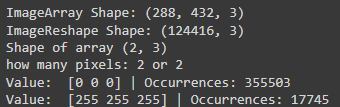

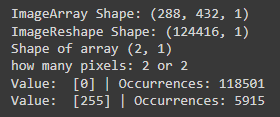

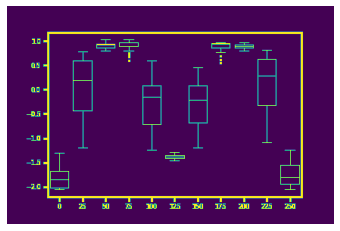

In [ ]:
image = array2img(train_x[16])
plt.axis('off')
plt.imshow(image)

-----------

### TESTE



#### Functions

In [ ]:
def get_model(width, height, channels):
  model = Sequential()

  model.add(Conv2D(16, (1, 1), activation='relu', input_shape=(width, height, channels)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(32, (1, 1), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (1, 1), activation='relu'))

  model.add(Flatten())

  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.7)) #Aumentar depois maybe o dropout
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.7))
  model.add(Dense(n_classes, activation='softmax'))

  # early stopping
  callback = EarlyStopping(monitor='loss')
  # compile model
  opt = keras.optimizers.Adam(learning_rate=0.0001)

  model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  
  return model

In [ ]:
def get_model2(width, height, channels):
  # define model
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(width, height, channels)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dense(n_classes, activation='softmax'))
  # early stopping
  callback = EarlyStopping(monitor='loss', patience=3)
  # compile model
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

#### Prepare Data

In [ ]:
# This cell is used to fix one hot encoding automatic from keras in some datasets
train_y = train_y.astype('uint8')
test_y = test_y.astype('uint8')
while(min(train_y) > 0):
  train_y = train_y - 1
while(min(test_y) > 0):
  test_y = test_y - 1

In [ ]:
print("Train: ", train_x.shape, " | y = ", train_y.size)
print("Test:  ", test_x.shape, " | y = ", test_y.size)
n_classes = np.unique(train_y).size
print("Number of classes: ", n_classes)

Train:  (36, 288, 432, 1)  | y =  36
Test:   (175, 288, 432, 1)  | y =  175
Number of classes:  3


In [ ]:
train_length, width, height, channels = train_x.shape[1], train_x.shape[2], train_x.shape[3]
print("Width: ", width, "| Height: ", height, "| Channels: ", channels)

Width:  288 | Height:  432 | Channels:  1


In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255.0)

In [ ]:
callbacks = [
    # keras.callbacks.ModelCheckpoint(
    #     "best_model.h5", save_best_only=True, monitor="val_loss"
    # ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

#### Training

In [ ]:
#Configs
BATCH_SIZE = 32 if train_length >= 500 else 16 if train_length >= 50 else 8
EPOCHS = 100
N_SPLIT = 5
verbose = 1

# Storing the average of all predictions
main_pred = []
data_kfold = pd.DataFrame()
acc_per_fold = []
loss_per_fold = []
row = []
row.append(name)

kfold = KFold(n_splits=N_SPLIT, shuffle=True) # , random_state=42)

# Variable for keeping count of split we are executing

fold_no = 0


# K-fold Train and test for each split

for train_idx, val_idx in list(kfold.split(train_x, train_y)):

    fold_no+=1

    # training_set  = datagen.flow(train_idx, train_y, batch_size=64)
    training_set  = datagen.flow(train_x[train_idx], train_y[train_idx], batch_size=BATCH_SIZE)
    
    validation_set = datagen.flow(train_x[val_idx], train_y[val_idx], batch_size=BATCH_SIZE)

    model_test = get_model(width, height, channels)
    history = model_test.fit( training_set,
                              validation_data=validation_set,
                              epochs = EPOCHS,
                              steps_per_epoch = len(training_set) ,
                              callbacks = callbacks,
                              verbose = verbose
                              )

    del(training_set)
    del(validation_set)

    test_set = datagen.flow(test_x, test_y, batch_size=BATCH_SIZE)

    pred = model_test.evaluate(test_set, steps=len(test_set))

    del(test_set)

    print(f'Score for fold {fold_no}: {model_test.metrics_names[0]} of {pred[0]}; {model_test.metrics_names[1]} of {pred[1]*100}%')
    acc_per_fold.append(pred[1])
    loss_per_fold.append(pred[0])

    # predicted_class_indices=np.argmax(pred,axis=1)
    # data_kfold[fold_no] = predicted_class_indices

    gc.collect()


Epoch 1/100
4/4 [==============================] - 1s 113ms/step - loss: 1.4189 - accuracy: 0.3571 - val_loss: 1.0763 - val_accuracy: 0.3750 - lr: 1.0000e-04
Epoch 2/100
4/4 [==============================] - 0s 61ms/step - loss: 1.5481 - accuracy: 0.3214 - val_loss: 1.0371 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 3/100
4/4 [==============================] - 0s 61ms/step - loss: 1.3988 - accuracy: 0.4286 - val_loss: 1.0465 - val_accuracy: 0.3750 - lr: 1.0000e-04
Epoch 4/100
4/4 [==============================] - 0s 64ms/step - loss: 2.0676 - accuracy: 0.2500 - val_loss: 1.0372 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 5/100
4/4 [==============================] - 0s 59ms/step - loss: 1.5245 - accuracy: 0.3214 - val_loss: 1.0677 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 6/100
4/4 [==============================] - 0s 60ms/step - loss: 1.1864 - accuracy: 0.5000 - val_loss: 1.0238 - val_accuracy: 0.3750 - lr: 1.0000e-04
Epoch 7/100
4/4 [==============================] - 0s 63m

In [ ]:

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i] * 100}%')
  row.append(loss_per_fold[i])
  row.append(acc_per_fold[i])

print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold) * 100} (+- {np.std(acc_per_fold) * 100})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

row.append(np.mean(acc_per_fold))
row.append(np.std(acc_per_fold))
row.append(np.mean(loss_per_fold))
row.append(BATCH_SIZE)
row.append(EPOCHS)

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.712115466594696 - Accuracy: 74.85714554786682%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.6811813116073608 - Accuracy: 70.28571367263794%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.7116196751594543 - Accuracy: 72.00000286102295%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.680374026298523 - Accuracy: 74.85714554786682%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.8067720532417297 - Accuracy: 72.00000286102295%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 72.8000020980835 (+- 1.7925022840095512)
> Loss: 0.7184125065803528
-------------------------------

In [ ]:
train_length = 5000
test = 

In [ ]:
test

32

#### Save Data

In [ ]:
zip_iterator = zip(columns, row)
a_dictionary = dict(zip_iterator)
print(a_dictionary)
test = df_csv
print(test, "\n ------------------------")
test = test.append(a_dictionary, ignore_index=True)

print(test)

In [ ]:
test.to_csv('teste.csv', index = False, header= True)

### CNN - Small version

#### Prepare Data

In [ ]:
# This cell is used to fix one hot encoding automatic from keras in some datasets
train_y = train_y.astype('uint8')
test_y = test_y.astype('uint8')
while(min(train_y) > 0):
  train_y = train_y - 1
while(min(test_y) > 0):
  test_y = test_y - 1

In [ ]:
print("Train: ", train_x.shape, " | y = ", train_y.size)
print("Test:  ", test_x.shape, " | y = ", test_y.size)
n_classes = np.unique(train_y).size
print("Number of classes: ", n_classes)

[254   0 254 ... 254   0 254]


In [ ]:
width, height, channels = train_x.shape[1], train_x.shape[2], train_x.shape[3]
print("Width: ", width, "| Height: ", height, "| Channels: ", channels)

Width:  288 | Height:  432 | Channels:  3


In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255.0)
# prepare an iterators to scale images
train_iterator = datagen.flow(train_x, train_y, batch_size=64) #DEPOIS SUSBTITUIR AO TRAVEZ POR TRAIN_Y e colocar no modelo aquilo que o nuno disse (ver notes)
test_iterator = datagen.flow(test_x, test_y, batch_size=64)
print('Batches train=%d, test=%d' % (len(train_iterator), len(test_iterator)))
# confirm the scaling works
batchX, batchy = train_iterator.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))


#### Model

In [ ]:
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()

In [ ]:
# define model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(width, height, channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
# early stopping
callback = EarlyStopping(monitor='loss', patience=3)
# compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# fit model with generator
history = model.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=30)

In [ ]:
# evaluate model
print('Test accuracy:')
_, acc = model.evaluate(test_iterator, steps=len(test_iterator))
print('Test Accuracy: %.3f' % (acc * 100))

#### History

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### CNN - Plotting Time - Test

#### Prepare Date TEST


In [ ]:
# This cell is used to fix one hot encoding automatic from keras in some datasets
train_y = train_y.astype('uint8')
test_y = test_y.astype('uint8')
while(min(train_y) > 0):
  train_y = train_y - 1
while(min(test_y) > 0):
  test_y = test_y - 1

In [ ]:
print("Train: ", train_x.shape, " | y = ", train_y.size)
print("Test:  ", test_x.shape, " | y = ", test_y.size)

Train:  (200, 288, 432, 1)  | y =  200
Test:   (242, 288, 432, 1)  | y =  242


In [ ]:
# train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], train_x.shape[2], 1))
# test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], test_x.shape[2], 1))
train_x = train_x[:,:,:,:1]
test_x = test_x[:,:,:,:1]
n_classes = np.unique(train_y).size
print("Number of classes: ", n_classes)

Number of classes:  6


In [ ]:
idx = np.random.permutation(len(train_x))
train_x = train_x[idx]
train_y = train_y[idx]

In [ ]:
width, height, channels = train_x.shape[1], train_x.shape[2], train_x.shape[3]
print("Width: ", width, "| Height: ", height, "| Channels: ", channels)

Width:  288 | Height:  432 | Channels:  1


#### Model

In [ ]:
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()

In [ ]:
# define model
model = Sequential()
# model.add(InputLayer(input_shape=(width, height, channels)))

model.add(Conv2D(16, (1, 1), activation='relu', input_shape=(width, height, channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (1, 1), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (1, 1), activation='relu'))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.7)) #Aumentar depois maybe o dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(n_classes, activation='softmax'))

# compile model
opt = keras.optimizers.Adam(learning_rate=0.0001)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

model.compile(
    optimizer = opt,
    loss = "sparse_categorical_crossentropy",
    metrics = ["sparse_categorical_accuracy"],
)

history = model.fit(
    train_x,
    train_y,
    batch_size=32,
    # batch_size=64,
    epochs=500,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1
)

Epoch 1/500
5/5 [==============================] - 8s 2s/step - loss: 1.9241 - sparse_categorical_accuracy: 0.1688 - val_loss: 1.7594 - val_sparse_categorical_accuracy: 0.2750 - lr: 1.0000e-04
Epoch 2/500
5/5 [==============================] - 7s 2s/step - loss: 1.8415 - sparse_categorical_accuracy: 0.2125 - val_loss: 1.7454 - val_sparse_categorical_accuracy: 0.4000 - lr: 1.0000e-04
Epoch 3/500
5/5 [==============================] - 8s 2s/step - loss: 1.8245 - sparse_categorical_accuracy: 0.2000 - val_loss: 1.7352 - val_sparse_categorical_accuracy: 0.4500 - lr: 1.0000e-04
Epoch 4/500
5/5 [==============================] - 7s 2s/step - loss: 1.7676 - sparse_categorical_accuracy: 0.2250 - val_loss: 1.7303 - val_sparse_categorical_accuracy: 0.3000 - lr: 1.0000e-04
Epoch 5/500
5/5 [==============================] - 1s 238ms/step - loss: 1.7345 - sparse_categorical_accuracy: 0.2625 - val_loss: 1.7310 - val_sparse_categorical_accuracy: 0.2750 - lr: 1.0000e-04
Epoch 6/500
5/5 [===============

In [ ]:
# model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(test_x, test_y)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

8/8 [==============================] - 0s 58ms/step - loss: 1.6227 - sparse_categorical_accuracy: 0.4545
Test accuracy 0.4545454680919647
Test loss 1.622735619544983


#### History

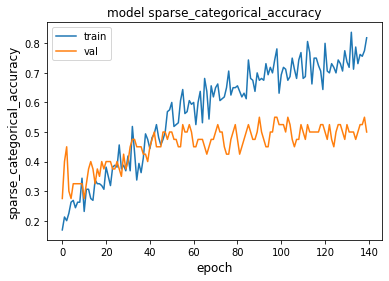

In [ ]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

### Extras

In [ ]:
# labels=(training_set.class_indices)
# labels2=dict((v,k) for k,v in labels.items())
import collections 
for i in range(len(data_kfold)):
    co = collections.Counter(data_kfold.loc[i])
    co = sorted(co.items(),key=lambda x: x[1],reverse=True)
    # ans.Class.loc[i] = labels2[co[0][0]]

In [ ]:
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()

O que alterei do Plotting Time:


*   Strides das Conv2D pus o default (1,1) (acho que isto já era suposto ser o default)
*   Dropout de 0.7 -> 0.5



In [ ]:
# define model
model = Sequential()
# model.add(InputLayer(input_shape=(width, height, channels)))

model.add(Conv2D(16, (1, 1), activation='relu', input_shape=(width, height, channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (1, 1), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (1, 1), activation='relu'))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5)) #Aumentar depois maybe o dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

# early stopping
callback = EarlyStopping(monitor='loss')
# compile model
opt = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# fit model with generator
history = model.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=100)

In [ ]:
# evaluate model
print('Test accuracy:')
_, acc = model.evaluate(test_iterator, steps=len(test_iterator))
print('Test Accuracy: %.3f' % (acc * 100))

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()